In [9]:
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import re


# Load the dictionary from the file
with open('experiments_process_and_results.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [17]:
loaded_dict['Exp_123']['load_sensor_process']

,Time_[s],SENSOR_MANDREL_AXIAL_Load_[kN],SENSOR_PRESSURE-DIE_LATERAL_1_Load_[kN],SENSOR_PRESSURE-DIE_LATERAL_2_Load_[kN]
0,0.0,0.0665856642553343,0.0372058309588285,-0.000158929314531654
1,0.01,0.0766354963322813,0.0365616109535339,0.000485290689805682
2,0.02,0.083335384384781,0.0339847309326278,-0.000158929314531654
3,0.03,0.083335384384781,0.0359173909482669,-0.00080314931886341
4,0.04,0.0967351604929541,0.0365616109535339,-0.00144736932318997
...,...,...,...,...
8650,86.5,0.0816604123715614,0.0346289509378143,0.00112951069414898
8651,86.51,0.0799854403584056,0.0378500509641511,0.00112951069414898
8652,86.52,0.0850103563980653,0.0391384909748819,-0.000158929314531654
8653,86.53,0.0766354963322813,0.0378500509641511,-0.00209158932751173


In [95]:
def extract_y_label(col_name: str) -> str:
    """
    Extracts signal type and unit for y-axis label.
    E.g., "MANDREL_AXIAL_Load_[kN]" -> "Load [kN]"
    """
    match = re.search(r'([A-Za-z0-9\- ]+_\[[^]]+\])$', col_name)
    return match.group(1).replace('_', ' ') if match else col_name.replace('_', ' ')

def extract_trace_name(col_name: str) -> str:
    """
    Extracts the part before the measurement and unit.
    E.g., "SENSOR_MANDREL_AXIAL_Load_[kN]" -> "SENSOR MANDREL AXIAL"
    """
    parts = col_name.split('_')
    for i in range(len(parts)):
        if re.match(r'^[A-Za-z0-9\-]+\_\[[^]]+\]$', '_'.join(parts[i:])):
            return ' '.join(parts[:i]).replace('_', ' ')
    return ' '.join(parts[:-2]).replace('_', ' ')



def multi_sensor_subplots(df: pd.DataFrame, 
                          save_fig=False, 
                          output_path="machine_process_flow.html") -> go.Figure:  
    
    time = df.iloc[:, 0]
    sensor_cols = df.columns[1:]

    numeric_cols = []
    for col in sensor_cols:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].notna().any():
                numeric_cols.append(col)
        except Exception:
            continue

    num_sensors = len(numeric_cols)

    # Subplot titles = descriptive sensor names (not units)
    subplot_titles = [extract_trace_name(col) for col in numeric_cols]

    fig = make_subplots(
        rows=num_sensors, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        subplot_titles=subplot_titles
    )

    for i, col in enumerate(numeric_cols, start=1):
        y_values = df[col]
        y_min = y_values.min()
        y_max = y_values.max()
        margin = (y_max - y_min) * 0.1 if y_max != y_min else 1

        fig.add_trace(
            go.Scatter(
                x=time,
                y=y_values,
                mode='lines',
                name=extract_trace_name(col),  # for tooltip only
                line=dict(width=1)
            ),
            row=i, col=1
        )

        fig.update_yaxes(
            title_text=extract_y_label(col),  # this is the y-axis label on left
            range=[y_min - margin, y_max + margin],
            row=i, col=1
        )

    fig.update_xaxes(title_text='Time [s]', row=num_sensors, col=1)

    fig.update_layout(
        # title="Sensor Time Series - One per Subplot",
        height=300 * num_sensors,
        width=1400,
        showlegend=False,
        hovermode='x unified'
    )

    if save_fig:
        fig.write_html(output_path)
        print(f"Interactive subplot saved to {output_path}")

    return fig

Interactive subplot saved to machine_process_flow.html


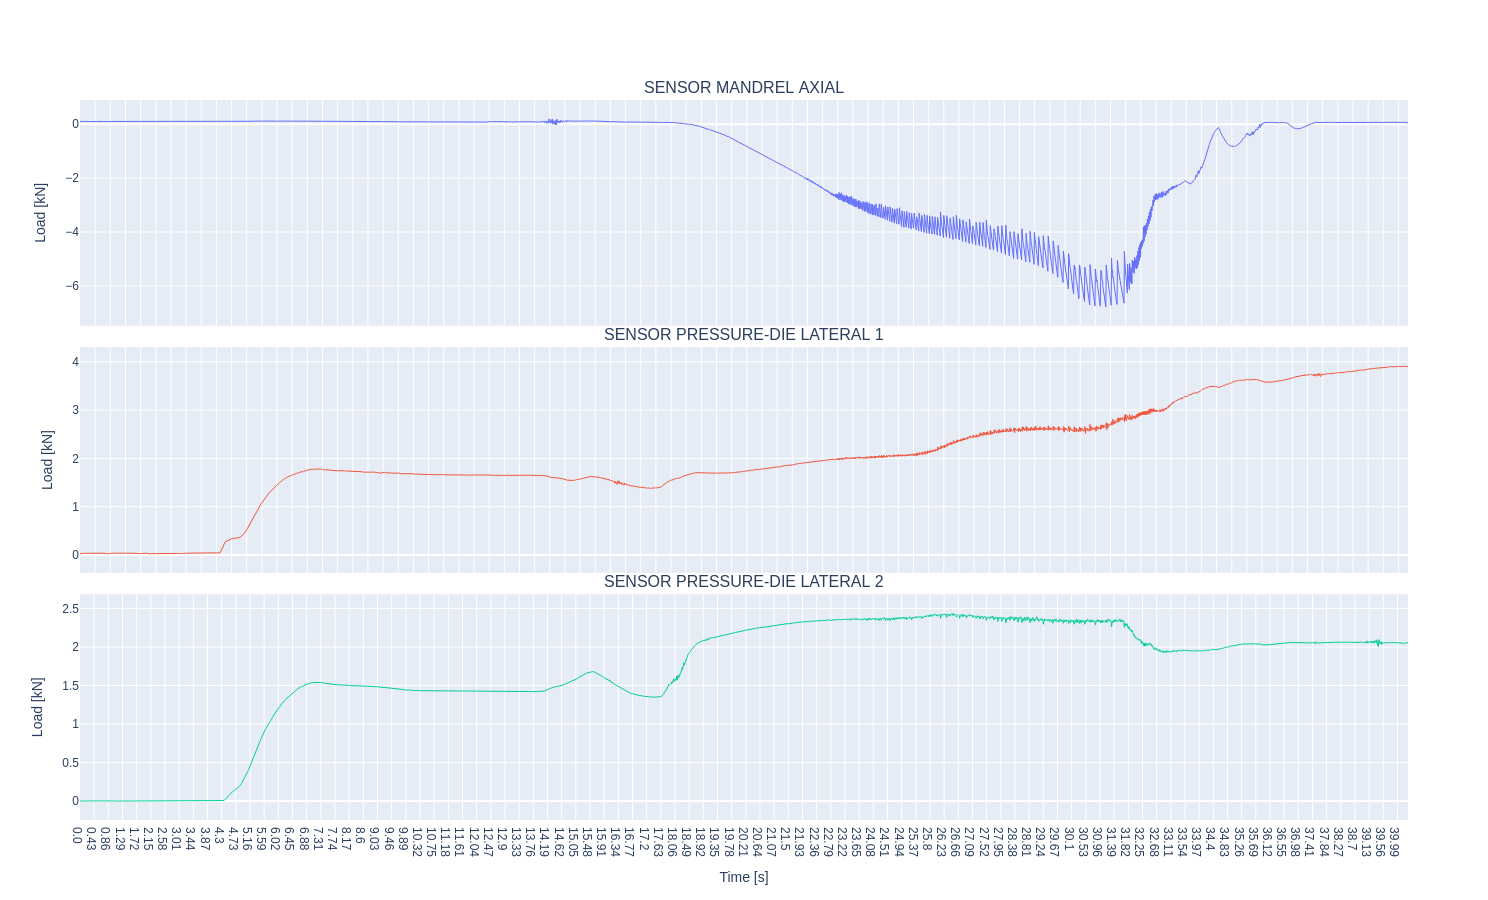

In [109]:
df = loaded_dict['Exp_11']['load_sensor_process']

multi_sensor_subplots(df, save_fig=True)

In [113]:
df.describe()

,SENSOR_MANDREL_AXIAL_Load_[kN],SENSOR_PRESSURE-DIE_LATERAL_1_Load_[kN],SENSOR_PRESSURE-DIE_LATERAL_2_Load_[kN]
count,4032.000000,4032.000000,4032.000000
mean,-1.229725,2.009354,1.673677
std,1.929566,1.050960,0.738735
min,-6.777361,0.023033,-0.001447
25%,-2.576521,1.619411,1.429366
50%,0.066586,1.770159,1.964070
75%,0.096735,2.622626,2.305507
max,0.202258,3.910915,2.439506
